**Note:** if you are working on LEAP-pangeo You would need to install the `gpflow` package to run this notebook. `gpflow` is built upon tensorflow and is widely used to build Gaussian process models in python.

You can type `pip install --upgrade tensorflow` and `pip install gpflow` in the Terminal Launcher.

OR

Use `conda install -c conda-forge gpflow` to install it.

Restart the kernal after installing new packages.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt

from esem import gp_model
from esem.utils import get_random_params
from sklearn.metrics import mean_squared_error, r2_score
import gpflow

2025-05-27 09:15:10.785263: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 09:15:10.797435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748358910.809459   56946 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748358910.813096   56946 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748358910.823608   56946 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Load data

In [2]:
#read in postprocessed history
ds = xr.open_dataset('CLM-PPE_LAI.nc')

In [3]:
# read in parameter sets (normalized)
lhckey = 'parameters_lhc220926.txt'
df = pd.read_csv(lhckey)
ppe_params = df.drop(columns='member')

### Gaussian process regression 
##### with ESEm package: https://esem.readthedocs.io/en/latest/installation.html

In [4]:
# ESEm Gaussian process emulator (default kernel)
# partition dataset in to training data and testing data (not seen during training)
n_test = 50
Y = ds.TLAI_global_avg_2010.isel(ens=slice(1,501))
X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
y_test, y_train = Y[:n_test], Y[n_test:]

# train emulator
emulator = gp_model(np.array(X_train),np.array(y_train))
emulator.train()


2025-05-27 09:15:28.036494: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


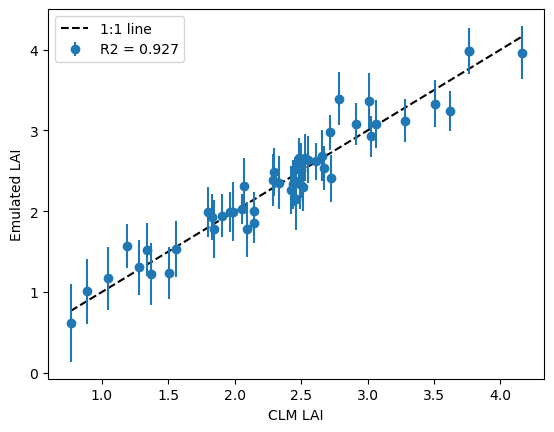

In [6]:
# validate emulator performance against testing data
y_pred, y_pred_variance = emulator.predict(X_test.values)
rms = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test,y_pred)

plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)],c='k',linestyle='--',label='1:1 line')
plt.errorbar(y_test, y_pred, yerr=2*y_pred_variance**0.5, fmt="o",label='R2 = '+str(np.round(r2,3)))
plt.xlabel('CLM LAI')
plt.ylabel('Emulated LAI')
plt.legend()

### My emulator looks terrible... now what?

#### Option 1: select a different kernel (covariance matrix)

In [7]:
# Define a few kernels
num_params = 32
kernel_noise = gpflow.kernels.White(variance=1e-3)
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=10, lengthscales = np.tile(10,32))
kernel_matern52 = gpflow.kernels.Matern52(active_dims=range(num_params),variance=1,lengthscales=np.tile(1,32))
kernel_bias = gpflow.kernels.Bias(active_dims = range(num_params))
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=[1.]*num_params)
kernel_poly = gpflow.kernels.Polynomial(active_dims = range(num_params),variance=[1.]*num_params)
kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))

# build your custom kernel
kernel = kernel_linear + kernel_RBF + kernel_poly + kernel_bias + kernel_noise

In [8]:
# retrain emulator with custom kernel
emulator = gp_model(np.array(X_train),np.array(y_train),kernel=kernel)
emulator.train()

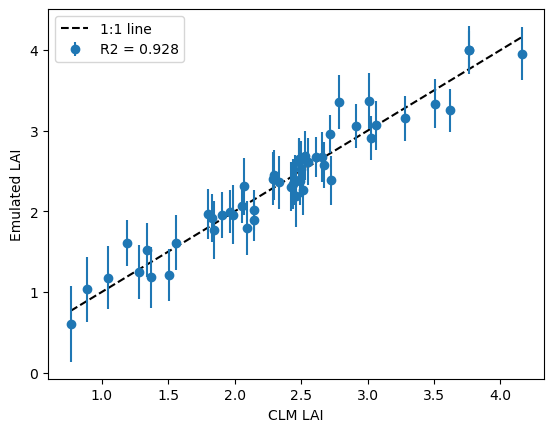

In [9]:
# validate
y_pred, y_pred_variance = emulator.predict(X_test.values)
rms = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test,y_pred)

plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)],c='k',linestyle='--',label='1:1 line')
plt.errorbar(y_test, y_pred, yerr=2*y_pred_variance**0.5, fmt="o",label='R2 = '+str(np.round(r2,3)))
plt.xlabel('CLM LAI')
plt.ylabel('Emulated LAI')
plt.legend()

#### standardize data before training

In [10]:
from sklearn.preprocessing import StandardScaler
 
# Step 1: Standardize Y
scaler = StandardScaler()
Y_standardized = scaler.fit_transform(Y.values.reshape(-1, 1))

X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
y_test, y_train = Y_standardized[:n_test], Y_standardized[n_test:]

emulator = gp_model(np.array(X_train),np.array(y_train))
emulator.train()

### My dataset is too large for Gaussian Process regression

#### Try a different tool : xgboost

In [21]:
from xgboost import XGBRegressor

ModuleNotFoundError: No module named 'xgboost'

In [61]:
n_test = 50
Y = ds.TLAI_global_avg_2010.isel(ens=slice(1,501))
X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
y_test, y_train = Y[:n_test], Y[n_test:]

# Initialize and train the XGBoost regressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

0.6025504632576728


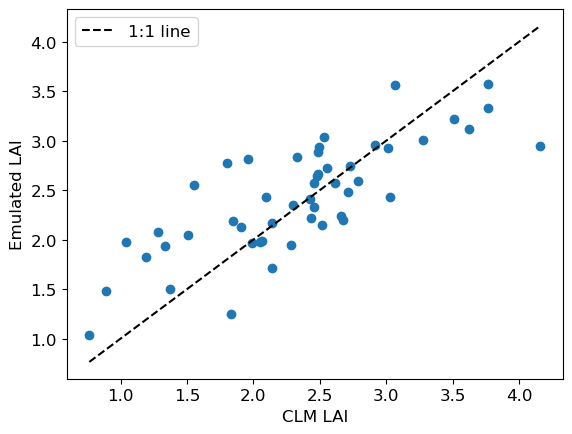

In [68]:
# Step 4: Make predictions and evaluate
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test,y_pred)
print(r2)

plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)],c='k',linestyle='--',label='1:1 line')
plt.scatter(y_test,y_pred)
plt.xlabel('CLM LAI')
plt.ylabel('Emulated LAI')
plt.legend()

#### Try a different tool: random forest

In [18]:
from esem import rf_model

In [19]:
# train 
n_test = 50
Y = ds.TLAI_global_avg_2010.isel(ens=slice(1,501))
X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
y_test, y_train = Y[:n_test], Y[n_test:]

emulator = rf_model(np.array(X_train),np.array(y_train))
emulator.train()


/glade/work/linnia/conda-envs/leap-reu-mf-2025/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.5225278463047958


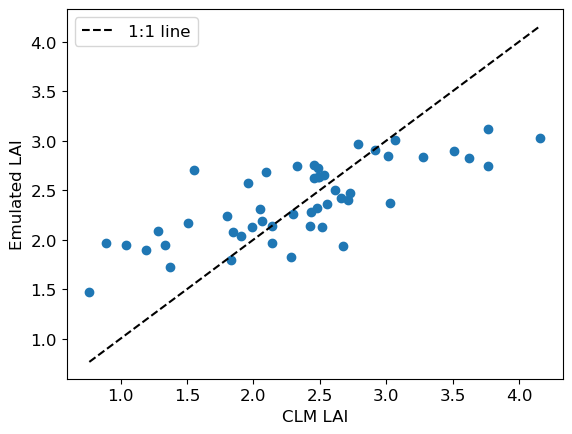

In [20]:
# validate
y_pred, _ = emulator.predict(X_test.values)
r2 = r2_score(y_test,y_pred)
print(r2)

plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)],c='k',linestyle='--',label='1:1 line')
plt.scatter(y_test,y_pred)
plt.xlabel('CLM LAI')
plt.ylabel('Emulated LAI')
plt.legend()

### My emulator looks good; now I want to run a sensitivity test

In [14]:
# https://salib.readthedocs.io/en/latest/
from SALib.sample import fast_sampler
from SALib.analyze import fast

In [15]:
# fourier amplitude sensitivity test
problem = {
    'names': ppe_params.columns,
    'num_vars': num_params,
    'bounds': [[0, 1]],
}

sample = fast_sampler.sample(problem, 1000, M=4, seed=None)

In [16]:
Y, _ = emulator.predict(sample)
FAST = fast.analyze(problem, Y, M=4, num_resamples=100, conf_level=0.95, print_to_console=False, seed=None)
sens = pd.DataFrame.from_dict(FAST)
sens.index = sens.names
df_sens = sens.sort_values(by=['S1'],ascending=False)

/glade/derecho/scratch/linnia/tmp/ipykernel_56946/2613139124.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


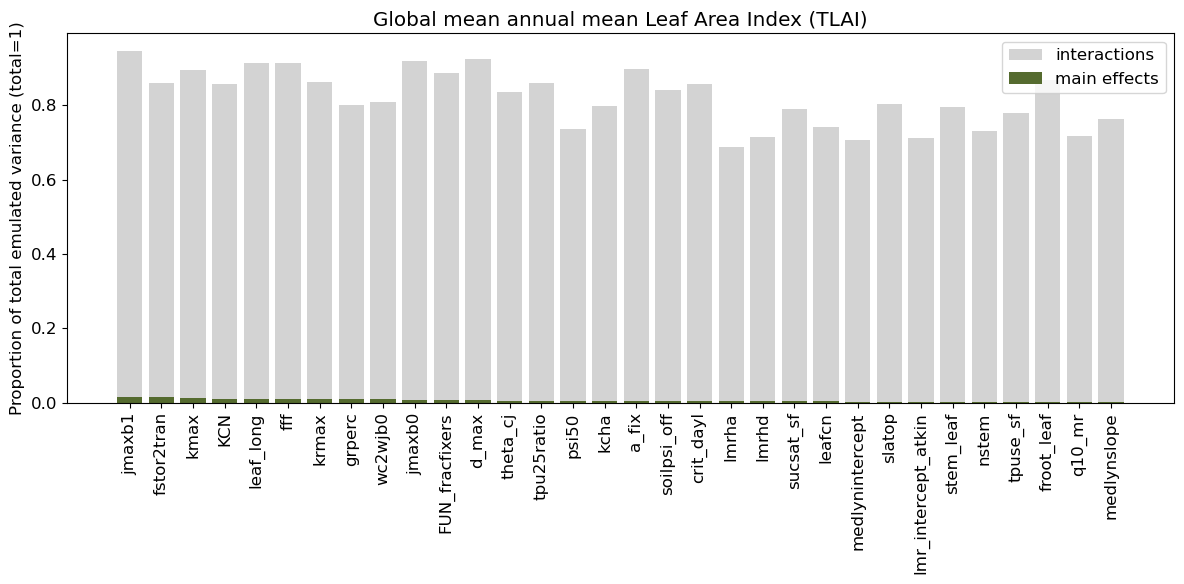

In [17]:
plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')
plt.subplot
plt.rcParams.update({'font.size': 12})

ax = plt.subplot(1,1,1)
ax.bar(df_sens.names,df_sens['ST'],color='lightgrey',label='interactions')
ax.bar(df_sens.names,df_sens['S1'],color='darkolivegreen',label='main effects')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.legend(loc='upper right')
plt.ylabel('Proportion of total emulated variance (total=1)')
plt.title('Global mean annual mean Leaf Area Index (TLAI)')
plt.tight_layout()

### My emulator looks good; now I want to emulate many new parameter sets

In [11]:
#############################################
# build sample
n_samples = 10000
n_params = 32
sample = np.random.uniform(size=n_params*n_samples).reshape(n_samples, n_params)

In [12]:
y_pred, y_pred_variance = emulator.predict(sample)

Text(0, 0.5, '# of samples')

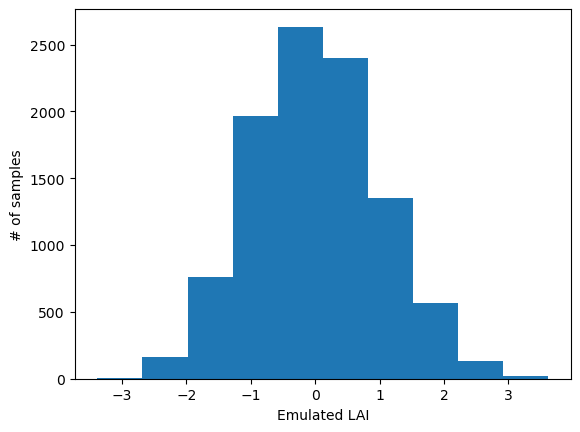

In [13]:
plt.hist(y_pred)
plt.xlabel('Emulated LAI')
plt.ylabel('# of samples')